# Trabalho redes Complexas

- Laura Gouveia                       9880200
- Luciano Augusto Campagnoli da Silva 9313367


## Introdução


Em sistemas complexos, o tráfego e a comunicação entre suas partes são de extrema importância para manter seu funcionamento. Vide o caso de células, em que moléculas orgâncias são transportadas por vias tubulares entre seus componentes para interagir com outras [1].  É possível analisar cidades representadas como redes complexas, interpretando como comunicação a circulação de pessoas por ela.

Este trabalho analisa o tráfego em redes complexas sob a perspectiva da informação necessária para deslocar entre ruas de uma cidade, utilizando uma rede alternativa para representá-la. As próximas seções são dispostas da seguinte maneira: na seção **Referencial Teórico**, discute-se acerca das referências na qual o escopo técnico deste projeto se baseia; na Seção **Métodos**, são descritos os processos e experimentos realizados, cujos resultados são exibidos em **Resultados e discussões**. Finaliza-se com a **Conclusão**, que sumariza as realizações atingidas e possibilidades a ser exploradas em trabalhos futuros.





## Referencial teórico

As técnicas deste trabalho são baseadas em [2], que propõe a análise de tráfego em cidades baseada na facilidade de fluxo de informações por suas vias. Para tanto, cria-se para elas uma representação em forma de grafos não direcionados, nos quais os vértices representam suas vias e as arestas as intersecções entre elas (contrariando o que convencionalmente poder-se-ia imaginar). Para simplificação, pressupõe-se que os custos de se movimentar pelas vias (ou de trocar de uma para outra) sejam uniformes, o que implicaria que o grafo seria não ponderado. O conceito é ilustrado pelas figuras a seguir:

![Figura 1: Representação de rede de informação em uma cidade fictícia em formato de estrela](./cidade_estrela.png "Figura 1: Rede de informação em uma cidade fictícia de formato de estrela")

![Figura 2: Representação de rede de informação em uma cidade fictícia em formato de grade](./cidade_grelha.png "Figura 2: Representação de rede de informação em uma cidade fictícia em formato de grade")

Em uma rede seguindo a estrutura proposta, pretende-se alcançar uma via **t** partindo de **s** através do(s) menor(es) caminho(s). Para tanto, a probabilidade de seguir um deles é dada por:


$$P[p(s,t)] = \frac{1}{k_{s}}\prod_{j \in p(s,t)}^{}\frac{1}{k_{j} - 1}$$   (1)


, na qual **j** representa todos os nós da trajetória antes de atingir o destino. O fator **kj - 1** , em contrapartida a **kj**, representa o ganho de informação ao seguir uma das saídas do nó (reduzindo as possibilidades em uma unidade). A probabilidade de seguir qualquer um dos caminhos mais curtos, portanto, dá-se pela soma das de cada um deles:

$$P(s -> t) = \sum_{}^{}P[p(s,t)]$$ (2).

Por fim, a métrica de informação de busca (*search information*) é calculdada obtendo-se a entropia da probabilidade da Equação 2:

$$S(s -> t) = - log_{2} \sum_{}^{}P[p(s,t)]$$ (3).

A partir da informação de busca, define-se a métrica **informação de acesso** (*access information*), que consiste na média da métrica SI de um nó de origem *s* para todos os seus destinos *t* possíveis:

$$A_{s} = \frac{1}{N}\sum_{t}^{}S(s, t)$$ (4)

Reciprocamente, pode-se definir o ocultamento de informação, que faz a média do SI para se alcançar **s** a partir de todas as origens **t possíveis:

$$H_{s} = \frac{1}{N}\sum_{t}^{}S(t, s)$$ (5)

Também pode-se definir a informação de busca média da rede como:

$$S = \frac{1}{N^2}\sum_{s}^{} \sum_{t}^{}S(s, t)$$ (5)

## Métodos

Utiliza-se as métricas apresentadas por [2] para analisar três cidades do estado de São Paulo: Corumbataí, Guará e São Caetano do Sul, com 4195 [3], 18606 [4] e 165655 [5] habitantes, segundo o último censo do IBGE (Instituo Brasileiro de Geografia e Estatística). As suas respectivas redes são importadas com a biblioteca OSMnx [6], nas quais as arestas representam as suas vias e os vértices os cruzamentos entre elas. Para adequar ao tipo de representação utilizada em [2], obtém-se as suas redes duais, invertendo o mapeamento de seus vértices e arestas.

Com os grafos no formato necessário, calcula-se a métrica de informação de busca para todos os pares de vértices possíveis de cada um deles, dispostos em matrizes de ordem N x N (com N sendo o número de vértices de cada rede). A implementação da computação é adaptada da biblioteca **bctpy** [7], otimizada para evitar o cálculo dos menores caminhos a cada iteração do algoritmo. A partir delas, obtém-se a informação de acesso e a informação de busca média.

Para cada uma das redes, cria-se uma aleatória baseadas no modelo Erdos-Reyni com o mesmo grau médio da existente e repete-se os processos anteriormente descritos. Com as métricas obtidas, calcula-se as métricas sigma e delta, que comparam as redes com as suas correspondentes aleatórias.

In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 3.4 MB/s eta 0:00:00


In [142]:
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from math import log2


*Download* das redes.

In [143]:
corumbatai = ox.graph_from_place("Corumbataí, Brazil")
guara = ox.graph_from_place("Guará, Brazil")
sao_caetano = ox.graph_from_place("São Caetano do Sul, Brazil")

display([corumbatai.number_of_nodes(), corumbatai.number_of_edges()])
display([guara.number_of_nodes(), guara.number_of_edges()])
display([sao_caetano.number_of_nodes(), sao_caetano.number_of_edges()])


[410, 978]

[2619, 7686]

[3903, 9392]

Exibição das redes descarregadas.

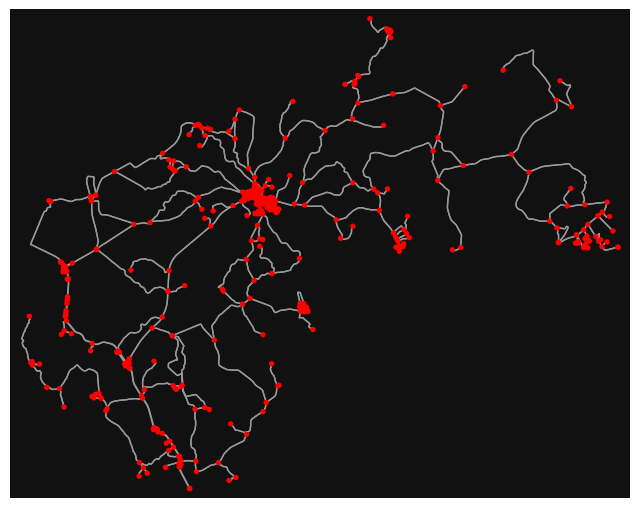

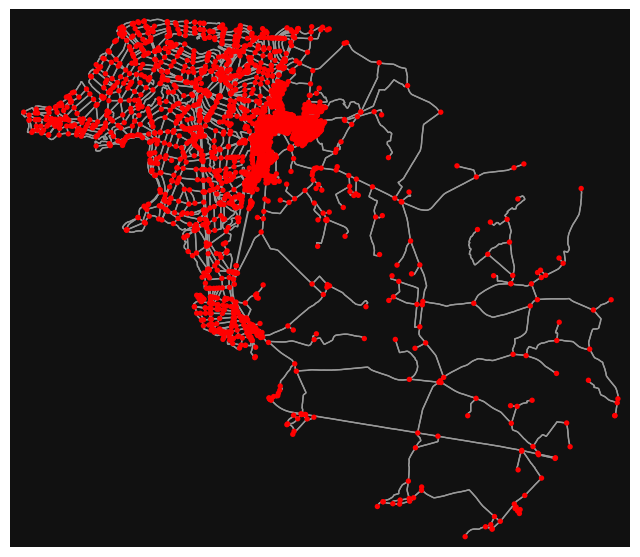

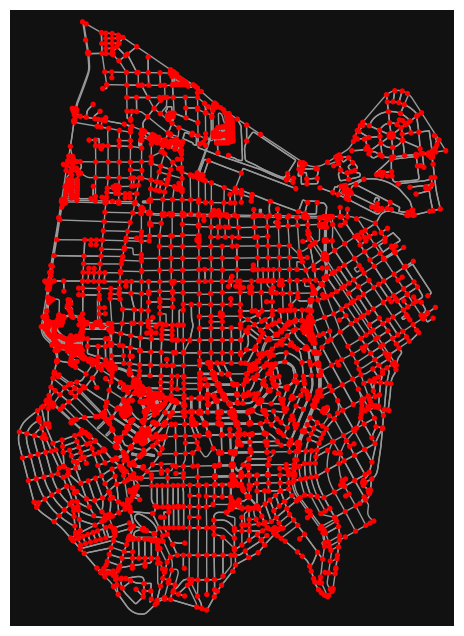

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [144]:
ox.plot_graph(corumbatai, node_color="red")
ox.plot_graph(guara, node_color="red")
ox.plot_graph(sao_caetano, node_color="red")

Função para renomear nós com seus índices.

In [145]:
def rename_nodes(graph: nx.Graph):
  mapping = {}
  count = 0

  for node in graph.nodes():
      mapping[node] = count
      count += 1

  return nx.relabel_nodes(graph, mapping)

Obtenção das redes duais.

In [146]:
[corumbatai_dual, guara_dual, sao_caetano_dual] = [
    rename_nodes(
        nx.line_graph(graph).to_undirected()
    ) for graph in [corumbatai, guara, sao_caetano]
]

display([corumbatai_dual.number_of_nodes(), corumbatai_dual.number_of_edges()])
display([guara_dual.number_of_nodes(), guara_dual.number_of_edges()])
display([sao_caetano_dual.number_of_nodes(), sao_caetano_dual.number_of_edges()])



[978, 2256]

[7686, 20741]

[9392, 21388]

Métrica Search-Information.

In [ ]:
def search_information(sp, adjacency, has_memory=False):
    start_time = time.time()
    print("Começo: ", time.ctime(start_time))

    N = len(adjacency)

    flag_triu = np.allclose(adjacency, adjacency.T)

    T = np.linalg.solve(np.diag(np.sum(adjacency, axis=1)), adjacency)
    print("Resolveu o sistema")

    SI = np.zeros((N, N))
    SI[np.eye(N) > 0] = np.nan

    for i in range(N):
        if (N % 1000 == 0):
            print("Nó ", N)

        for j in range(N):
            if (j > i and flag_triu) or (not flag_triu and i != j):
                path = sp[i][j]
                lp = len(path) - 1

                if flag_triu:
                    if np.any(path):
                        pr_step_ff = np.zeros(lp)
                        pr_step_bk = np.zeros(lp)

                        if has_memory:
                            pr_step_ff[0] = T[path[0], path[1]]
                            pr_step_bk[lp-1] = T[path[lp], path[lp-1]]
                            for z in range(1, lp):
                                pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])
                                pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
                        else:
                            for z in range(lp):
                                pr_step_ff[z] = T[path[z], path[z+1]]
                                pr_step_bk[z] = T[path[z+1], path[z]]

                        prob_sp_ff = np.prod(pr_step_ff)
                        prob_sp_bk = np.prod(pr_step_bk)

                        SI[i, j] = -np.log2(prob_sp_ff)
                        SI[j, i] = -np.log2(prob_sp_bk)
                else:
                    if np.any(path):
                        pr_step_ff = np.zeros(lp)
                        if has_memory:
                            pr_step_ff[0] = T[path[0], path[1]]
                            for z in range(1, lp):
                                pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])
                        else:
                            for z in range(lp):
                                pr_step_ff[z] = T[path[z], path[z+1]]

                        prob_sp_ff = np.prod(pr_step_ff)
                        SI[i, j] = -np.log2(prob_sp_ff)
                    else:
                        SI[i, j] = np.inf

    print("SI calculado com sucesso! Tempo: ", time.time() - start_time)
    return SI


Access Information.

In [ ]:
def access_information(search_information_matrix):
  search_information_matrix = np.nan_to_num(search_information_matrix, nan=0)
  sf_size = len(search_information_matrix)

  AI = []

  for index in range(len(search_information_matrix)):
    AI.append(
        np.nan_to_num(search_information_matrix[index], nan=0).sum()/sf_size
    )

  return AI


In [ ]:
corumbatai_search_information_matrix = search_information(corumbatai_dual, False)
corumbatai_si_df = pd.DataFrame(corumbatai_search_information_matrix)
corumbatai_si_df

Começo:  Mon Jun 23 20:47:13 2025


<class 'networkx.utils.decorators.argmap'> compilation 34:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


SI calculado com sucesso! Tempo:  9.311583280563354


,0,1,2,3,4,5,6,7,8,9,...,968,969,970,971,972,973,974,975,976,977
0,NaN,2.000000,3.000000,19.924813,21.924813,21.924813,10.000000,8.000000,12.000000,18.339850,...,60.286559,24.609640,-0.000000,22.924813,25.398744,26.661778,32.101494,25.076816,23.076816,30.516531
1,3.000000,NaN,1.000000,17.924813,19.924813,19.924813,11.000000,9.000000,13.000000,19.339850,...,58.286559,25.609640,1.000000,20.924813,26.398744,27.661778,33.101494,26.076816,24.076816,31.516531
2,5.000000,2.000000,NaN,16.924813,18.924813,18.924813,13.000000,11.000000,15.000000,21.339850,...,57.286559,27.609640,3.000000,19.924813,28.398744,29.661778,36.067278,28.076816,26.076816,34.482315
3,21.924813,18.924813,16.924813,NaN,2.000000,2.000000,24.339850,27.720672,26.339850,20.584963,...,70.211371,41.745350,19.509775,3.000000,26.228819,27.491853,25.491853,25.906891,23.906891,23.906891
4,22.924813,19.924813,17.924813,1.000000,NaN,3.000000,22.339850,25.720672,24.339850,18.584963,...,71.211371,39.745350,20.509775,1.000000,24.228819,25.491853,23.491853,23.906891,21.906891,21.906891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,27.661778,27.661778,28.661778,26.491853,25.491853,25.491853,15.661778,17.661778,17.661778,11.906891,...,81.709980,28.831703,25.661778,23.491853,9.228819,NaN,1.000000,1.000000,2.584963,2.000000
974,33.101494,33.101494,35.067278,24.491853,23.491853,23.491853,17.661778,19.661778,19.661778,13.906891,...,79.709980,30.831703,31.101494,21.491853,6.906891,1.000000,NaN,2.000000,3.584963,1.000000
975,26.661778,26.661778,27.661778,25.491853,24.491853,24.491853,14.661778,16.661778,16.661778,10.906891,...,80.709980,27.831703,24.661778,22.491853,8.228819,1.584963,2.584963,NaN,1.584963,1.584963
976,25.076816,25.076816,26.076816,23.906891,22.906891,22.906891,13.076816,15.076816,15.076816,9.321928,...,79.125018,26.246741,23.076816,20.906891,6.643856,3.584963,4.584963,2.000000,NaN,4.000000


In [ ]:
corumbatai_si_df = pd.read_csv("corumbatai.csv")
#corumbatai_si_df.to_csv("corumbatai.csv")

In [ ]:
sp = dict(nx.shortest_path(guara_dual))
adjacency = nx.adjacency_matrix(guara_dual).todense()

guara_search_information_matrix = search_information(sp=sp, adjacency=adjacency, has_memory=True)
guara_si_df = pd.DataFrame(guara_search_information_matrix)
guara_si_df

Começo:  Mon Jun 23 23:03:40 2025
Resolveu o sistema


C:\Users\lucia\AppData\Local\Temp\ipykernel_8664\2975086080.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
C:\Users\lucia\AppData\Local\Temp\ipykernel_8664\2975086080.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])


SI calculado com sucesso! Tempo:  791.8195059299469


,0,1,2,3,4,5,6,7,8,9,...,7676,7677,7678,7679,7680,7681,7682,7683,7684,7685
0,NaN,1.584963,1.584963,2.584963,5.000000,14.339850,13.339850,15.924813,17.094738,17.094738,...,50.243900,50.243900,50.799115,48.799115,48.799115,48.185007,31.586591,33.323556,33.323556,33.323556
1,2.321928,NaN,3.584963,4.584963,4.000000,13.339850,12.339850,14.924813,16.094738,16.094738,...,49.243900,49.243900,49.799115,47.799115,47.799115,47.185007,30.586591,32.323556,32.323556,32.323556
2,2.000000,3.169925,NaN,4.169925,6.584963,15.924813,14.924813,17.509775,18.679700,18.679700,...,51.828863,51.828863,52.384078,50.384078,50.384078,49.769969,33.171553,34.908519,34.908519,34.908519
3,1.584963,2.584963,2.584963,NaN,1.000000,12.509775,11.509775,14.094738,15.264663,15.264663,...,45.658938,45.658938,46.214153,44.214153,44.214153,43.600044,27.001628,28.738594,28.738594,28.738594
4,5.491853,3.584963,6.754888,2.000000,NaN,12.509775,11.509775,14.094738,15.264663,15.264663,...,45.658938,45.658938,46.214153,44.214153,44.214153,43.600044,27.001628,28.738594,28.738594,28.738594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7681,49.243900,47.337010,50.506935,45.752047,44.752047,40.505307,41.090269,42.412197,40.675232,40.675232,...,2.321928,2.321928,6.321928,4.321928,4.321928,NaN,30.679700,31.323556,29.509775,30.908519
7682,32.323556,30.416666,33.586591,28.831703,27.831703,35.416666,34.416666,37.001628,38.171553,38.171553,...,30.416666,30.416666,26.738594,27.060522,27.060522,30.416666,NaN,2.321928,2.321928,2.321928
7683,33.323556,31.416666,34.586591,29.831703,28.831703,36.416666,35.416666,38.001628,39.171553,39.171553,...,28.645484,28.645484,26.323556,26.645484,26.645484,30.230447,1.584963,NaN,3.321928,3.321928
7684,33.323556,31.416666,34.586591,29.831703,28.831703,36.416666,35.416666,38.001628,39.171553,39.171553,...,28.416666,28.416666,26.831703,27.153631,27.153631,28.416666,1.584963,3.321928,NaN,3.321928


In [46]:
# guara_si_df.to_csv("guara.csv")
guara_si_df = pd.read_csv("guara.csv").drop(columns=["Unnamed: 0"])

In [ ]:
sp = dict(nx.shortest_path(sao_caetano_dual))
adjacency = nx.adjacency_matrix(sao_caetano_dual).todense()

sao_caetano_search_information_matrix = search_information(sp=sp, adjacency=adjacency, has_memory=True)
sao_caetano_si_df = pd.DataFrame(sao_caetano_search_information_matrix)
sao_caetano_si_df

Começo:  Tue Jun 24 00:20:19 2025
Resolveu o sistema


C:\Users\lucia\AppData\Local\Temp\ipykernel_10852\2975086080.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
C:\Users\lucia\AppData\Local\Temp\ipykernel_10852\2975086080.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])


SI calculado com sucesso! Tempo:  1289.0166945457458


,0,1,2,3,4,5,6,7,8,9,...,9382,9383,9384,9385,9386,9387,9388,9389,9390,9391
0,NaN,2.000000,2.000000,2.000000,3.584963,5.169925,5.169925,10.339850,8.924813,11.924813,...,123.469278,122.113134,121.469278,121.469278,71.589847,74.437844,74.437844,70.700878,72.437844,74.437844
1,2.000000,NaN,3.584963,3.584963,2.000000,3.584963,3.584963,11.924813,10.509775,18.042600,...,123.791206,122.435062,121.791206,121.791206,73.174809,76.022806,76.022806,72.285841,74.022806,76.022806
2,2.321928,4.000000,NaN,4.000000,5.584963,4.584963,7.169925,12.339850,10.924813,18.457637,...,121.884315,120.528171,119.884315,119.884315,73.589847,76.437844,76.437844,72.700878,74.437844,76.437844
3,2.321928,4.000000,4.000000,NaN,5.584963,4.584963,7.169925,12.339850,10.924813,17.720672,...,124.206243,122.850100,122.206243,122.206243,73.589847,76.437844,76.437844,72.700878,74.437844,76.437844
4,3.584963,2.000000,5.169925,5.169925,NaN,2.000000,2.000000,10.339850,8.924813,11.924813,...,123.054240,121.698096,121.054240,121.054240,71.589847,74.437844,74.437844,70.700878,72.437844,74.437844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9387,74.945991,76.530953,76.530953,76.530953,74.945991,76.530953,76.530953,68.191103,69.776066,69.776066,...,71.822165,69.822165,69.822165,69.822165,56.645484,NaN,4.321928,4.321928,2.321928,4.321928
9388,73.945991,75.530953,75.530953,75.530953,73.945991,75.530953,75.530953,67.191103,68.776066,68.776066,...,74.822165,72.822165,72.822165,72.822165,55.645484,3.321928,NaN,3.321928,1.584963,3.321928
9389,70.945991,72.530953,72.530953,72.530953,70.945991,72.530953,72.530953,64.191103,65.776066,65.776066,...,75.407128,73.407128,73.407128,73.407128,52.645484,4.321928,4.321928,NaN,2.321928,4.321928
9390,71.945991,73.530953,73.530953,73.530953,71.945991,73.530953,73.530953,65.191103,66.776066,66.776066,...,72.822165,70.822165,70.822165,70.822165,53.645484,1.584963,1.584963,1.584963,NaN,5.321928


In [45]:
# sao_caetano_si_df.to_csv("sao_caetano_2.csv")
sao_caetano_si_df = pd.read_csv("sao_caetano_2.csv").drop(columns=["Unnamed: 0"])

In [122]:
def average_search_information(search_information_matrix: pd.DataFrame):
  return search_information_matrix.replace([np.inf, -np.inf], np.nan).sum().sum()/((len(search_information_matrix)) ** 2)

In [102]:
corumbatai_ai = access_information(corumbatai_si_df)

corumbatai_ai_df = pd.DataFrame(corumbatai_ai)
corumbatai_ai_df

,0
0,36.131516
1,35.349474
2,35.354400
3,46.429005
4,46.265866
...,...
973,52.597019
974,51.168597
975,51.604948
976,50.036095


In [124]:
avg_sao_carlos_sf = average_search_information(sao_caetano_si_df)
avg_sao_carlos_sf

60.04343080386927

Função para pegar métricas de um grafo.

In [17]:
def measures(G):
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    #av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1,k2,variance,l,r

medidas_corumbatai = measures(corumbatai_dual)
medidas_guara = measures(guara_dual)
medidas_sao_caetano = measures(sao_caetano_dual)

Função para geração de rede aleatória Erdos-Reiny.

In [18]:
def generate_er(N, av_degree):
  GER = nx.gnp_random_graph(N, av_degree/N, seed=None, directed=False)
  Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
  GER = GER.subgraph(Gcc[0])

  return nx.convert_node_labels_to_integers(GER, first_label=0)


GER_corumbatai = generate_er(corumbatai_dual.number_of_nodes(), medidas_corumbatai[0])
GER_guara = generate_er(guara_dual.number_of_nodes(), medidas_guara[0])
GER_sao_caetano = generate_er(sao_caetano_dual.number_of_nodes(), medidas_sao_caetano[0])


Cálculo para SI das redes aleatórias.

In [19]:
GER_corumbatai_sf = search_information(
    sp = dict(nx.shortest_path(GER_corumbatai)),
    adjacency = nx.adjacency_matrix(GER_corumbatai).todense(),
    has_memory=True
)

GER_corumbatai_sf_df = pd.DataFrame(GER_corumbatai_sf)
GER_corumbatai_sf_df

<class 'networkx.utils.decorators.argmap'> compilation 77:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


Começo:  Thu Jun 26 18:48:31 2025
Resolveu o sistema


/tmp/ipykernel_3517/1751800169.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
/tmp/ipykernel_3517/1751800169.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])


SI calculado com sucesso! Tempo:  6.6914355754852295


,0,1,2,3,4,5,6,7,8,9,...,954,955,956,957,958,959,960,961,962,963
0,NaN,10.884171,12.714246,14.199672,8.614710,7.129283,12.621136,9.977280,13.147205,10.521600,...,12.621136,11.591990,11.299208,9.784635,14.884171,11.106563,9.392317,11.129283,10.299208,10.521600
1,10.936638,NaN,9.784635,10.714246,14.562242,4.807355,5.392317,9.977280,9.936638,12.258566,...,13.258566,10.521600,10.714246,12.299208,10.299208,12.521600,10.129283,12.943064,9.936638,11.299208
2,12.321928,9.451211,NaN,11.398744,8.643856,7.906891,10.773139,12.983706,14.568669,9.813781,...,11.398744,11.884171,6.643856,12.813781,10.398744,6.906891,10.884171,12.135709,13.398744,10.076816
3,11.614710,7.977280,8.906891,NaN,11.714246,10.714246,8.714246,10.129283,13.539522,13.428491,...,2.321928,8.199672,9.199672,10.784635,10.169925,11.106563,12.129283,11.451211,10.129283,10.743993
4,6.977280,12.562242,7.228819,12.621136,NaN,9.321928,8.228819,11.813781,10.562242,1.584963,...,12.106563,10.299208,8.906891,12.076816,9.977280,12.299208,11.491853,6.906891,11.813781,8.491853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,9.977280,11.147205,5.977280,12.562242,12.924813,8.754888,7.491853,9.076816,11.509775,10.661778,...,8.714246,7.491853,11.299208,8.754888,11.246741,NaN,11.977280,9.661778,9.076816,8.924813
960,8.807355,9.392317,9.714246,13.321928,11.906891,8.321928,9.392317,12.936638,8.491853,12.339850,...,14.591990,9.936638,9.936638,10.754888,13.129283,12.422065,NaN,10.299208,12.936638,11.936638
961,9.321928,11.076816,10.714246,12.321928,7.000000,11.491853,6.321928,8.321928,12.199672,8.169925,...,12.784635,6.584963,9.392317,14.076816,11.339850,9.339850,9.977280,NaN,7.807355,12.147205
962,9.509775,8.562242,12.924813,11.754888,12.509775,8.076816,8.562242,4.906891,7.977280,10.924813,...,9.661778,10.147205,9.562242,13.831703,11.094738,9.339850,12.562242,8.299208,NaN,10.509775


In [20]:
GER_corumbatai_sf_df.to_csv("ger_corumbatai.csv")

In [ ]:
GER_guara_sf = search_information(
    sp = dict(nx.shortest_path(GER_guara)),
    adjacency = nx.adjacency_matrix(GER_guara).todense(),
    has_memory=True
)

GER_guara_sf_df = pd.DataFrame(GER_guara_sf)
GER_guara_sf_df

<class 'networkx.utils.decorators.argmap'> compilation 77:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


Começo:  Wed Jun 25 21:51:47 2025
Resolveu o sistema


/tmp/ipykernel_11096/1751800169.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
/tmp/ipykernel_11096/1751800169.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])


SI calculado com sucesso! Tempo:  440.48361897468567


,0,1,2,3,4,5,6,7,8,9,...,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651
0,NaN,12.398744,12.299208,10.813781,12.983706,15.299208,15.206099,17.042600,13.843529,11.076816,...,13.451211,3.000000,12.007027,15.813781,14.791061,12.851749,15.206099,13.398744,11.714246,16.106563
1,12.661778,NaN,14.273213,10.621136,13.036174,12.076816,16.568669,15.983706,13.509775,13.106563,...,9.754888,10.550747,12.924813,9.491853,9.491853,15.094738,12.106563,13.924813,15.076816,11.076816
2,13.661778,15.287712,NaN,13.621136,13.228819,12.451211,12.813781,16.416995,15.831703,12.813781,...,16.813781,9.714246,12.287712,15.491853,15.398744,12.688250,11.884171,15.983706,13.491853,9.906891
3,13.273213,12.398744,14.565995,NaN,13.913918,14.317130,18.639058,12.813781,16.639058,10.299208,...,14.758640,12.799282,13.924813,13.076816,13.568669,13.902092,16.147205,8.784635,12.799282,14.509775
4,14.076816,13.550747,13.036174,12.784635,NaN,11.392317,12.169925,14.076816,17.588715,14.813781,...,10.392317,15.258566,11.392317,15.714246,10.321928,16.147205,12.584963,13.339850,14.936638,13.169925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7647,12.906891,14.562242,11.366322,11.714246,15.299208,14.983706,15.135709,15.813781,12.451211,15.398744,...,18.206099,16.784635,13.813781,11.321928,13.509775,NaN,11.451211,13.491853,12.321928,16.299208
7648,16.831703,13.106563,12.147205,15.521600,13.147205,13.369597,12.509775,11.228819,15.691525,11.339850,...,12.562242,16.977280,11.299208,15.714246,12.813781,12.951285,NaN,13.076816,13.983706,12.339850
7649,14.568669,14.621136,15.858175,7.906891,13.416666,11.135709,15.720672,11.661778,13.791061,13.036174,...,13.451211,12.758640,13.720672,14.550747,11.398744,14.568669,12.813781,NaN,12.135709,14.206099
7650,12.813781,15.983706,13.469133,11.661778,15.276488,15.568669,13.983706,15.943064,14.884171,12.884171,...,14.451211,17.121210,13.299208,12.451211,14.273213,13.621136,13.831703,12.076816,NaN,12.661778


In [47]:
#GER_guara_sf_df.to_csv("ger_guara.csv")
GER_guara_sf_df = pd.read_csv("ger_guara.csv").drop(columns=["Unnamed: 0"])

In [ ]:
sp = dict(nx.shortest_path(GER_sao_caetano))
print("Shortest path calculated!")

GER_sao_caetano_sf = search_information(
    sp = sp,
    adjacency = nx.adjacency_matrix(GER_sao_caetano).todense(),
    has_memory=True
)

GER_sao_caetano_sf_df = pd.DataFrame(GER_sao_caetano_sf)
GER_sao_caetano_sf_df

Shortest path calculated!
Começo:  Thu Jun 26 00:29:50 2025
Resolveu o sistema


C:\Users\lucia\AppData\Local\Temp\ipykernel_18192\1751800169.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
C:\Users\lucia\AppData\Local\Temp\ipykernel_18192\1751800169.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])


SI calculado com sucesso! Tempo:  503.7876846790314


,0,1,2,3,4,5,6,7,8,9,...,9275,9276,9277,9278,9279,9280,9281,9282,9283,9284
0,NaN,12.784635,13.199672,15.754888,15.135709,11.392317,15.714246,14.199672,11.813781,15.906891,...,13.754888,14.036174,12.392317,18.691525,16.299208,12.714246,12.754888,12.714246,16.366322,15.339850
1,13.369597,NaN,8.392317,13.076816,6.392317,12.199672,16.328955,16.147205,17.469133,17.977280,...,18.176952,14.813781,16.469133,17.924813,13.621136,14.021674,16.951285,18.539522,10.392317,9.977280
2,14.539522,9.147205,NaN,13.791061,13.076816,13.884171,11.339850,15.884171,19.428491,16.720672,...,12.754888,14.398744,11.339850,17.831703,14.398744,10.661778,11.135709,14.568669,12.299208,16.305634
3,16.831703,13.568669,13.884171,NaN,17.791061,13.884171,9.661778,15.176952,11.299208,17.621136,...,9.398744,12.135709,12.754888,12.076816,12.691525,12.398744,13.491853,11.661778,14.884171,14.094738
4,14.720672,5.754888,11.550747,16.206099,NaN,13.983706,11.720672,16.750419,18.502032,16.076816,...,13.983706,5.491853,12.661778,18.983706,11.813781,14.173677,13.813781,13.036174,14.884171,15.720672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9280,14.054096,14.691525,10.661778,12.398744,16.206099,15.299208,10.924813,18.428491,17.305634,18.398744,...,10.398744,13.884171,15.791061,16.153631,16.206099,NaN,11.884171,14.568669,10.299208,17.983706
9281,13.169925,16.343602,10.076816,12.392317,14.339850,13.491853,16.076816,14.076816,11.643856,19.758640,...,14.299208,11.339850,10.754888,13.299208,16.983706,10.754888,NaN,11.807355,13.459432,13.339850
9282,13.521600,18.761915,14.299208,11.392317,14.428491,14.199672,17.358703,15.743993,13.936638,16.199672,...,15.036174,10.743993,16.621136,20.820808,17.884171,14.299208,12.369597,NaN,15.659104,13.621136
9283,17.080568,10.754888,11.784635,14.491853,15.884171,12.299208,14.884171,12.299208,19.913918,14.714246,...,16.661778,13.246741,16.369597,12.732167,12.299208,9.754888,14.021674,15.659104,NaN,15.246741


In [48]:
#GER_sao_caetano_sf_df.to_csv("ger_sao_caetano.csv")
GER_sao_caetano_sf_df = pd.read_csv("ger_sao_caetano.csv").drop(columns=["Unnamed: 0"])

Distribuição de grau.

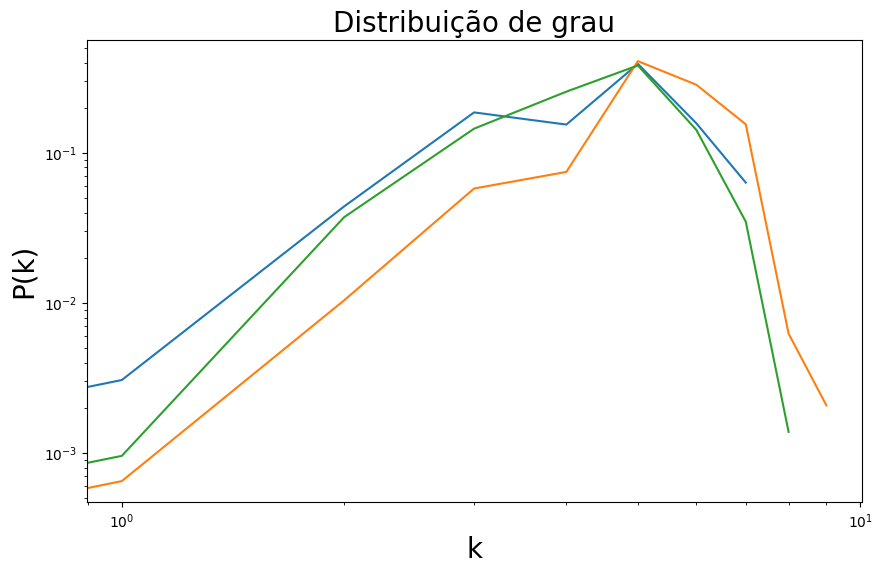

In [150]:
def degree_distribution(graph):
    vk = dict(graph.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

ks_c, Pk_c = degree_distribution(corumbatai_dual)
ks_g, Pk_g = degree_distribution(guara_dual)
ks_s, Pk_s = degree_distribution(sao_caetano_dual)

plt.figure(figsize=(10,6))
fig = plt.subplot(1,1,1)
fig.set_xscale('log')
fig.set_yscale('log')

plt.plot(ks_c,Pk_c, label= "Corumbataí")
plt.plot(ks_g,Pk_g, label = "Guará")
plt.plot(ks_s,Pk_s, label = "São Caetano do Sul")
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Distribuição de grau", fontsize=20)

plt.show()



Cálculo das métricas sigma e delta.

In [ ]:
def sigma_delta(graph_sf_df, random_graph_sf_df):
  #random_graph_sf_df.replace([np.inf, -np.inf], np.nan, inplace=True)

  avg_graph_sf = average_search_information(graph_sf_df)
  GER_avg_sf = average_search_information(random_graph_sf_df)

  sigma = avg_graph_sf/log2(len(graph_sf_df))
  delta = (avg_graph_sf - GER_avg_sf)/log2(len(graph_sf_df))

  return (sigma, delta)

sigma_delta_metrics_corumbatai = sigma_delta(corumbatai_si_df, GER_corumbatai_sf_df)
sigma_delta_metrics_guara = sigma_delta(guara_si_df, GER_guara_sf_df)
sigma_delta_metrics_sao_caetano = sigma_delta(sao_caetano_si_df, GER_sao_caetano_sf_df)







<Figure size 1000x600 with 0 Axes>

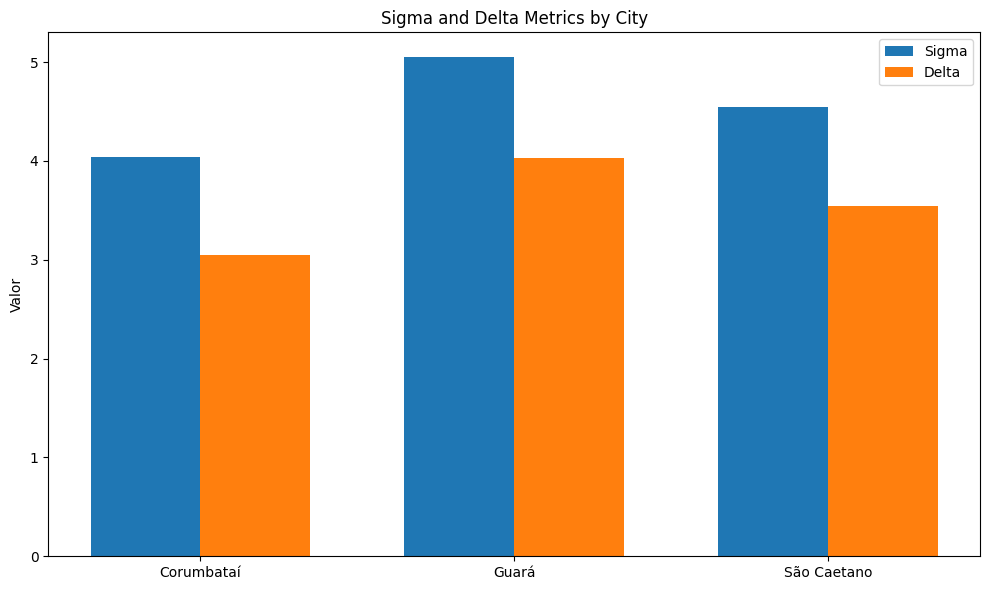

In [ ]:
plt.figure(figsize=(10, 6))

cities = ['Corumbataí', 'Guará', 'São Caetano']
sigma_values = [sigma_delta_metrics_corumbatai[0], sigma_delta_metrics_guara[0], sigma_delta_metrics_sao_caetano[0]]
delta_values = [sigma_delta_metrics_corumbatai[1], sigma_delta_metrics_guara[1], sigma_delta_metrics_sao_caetano[1]]

x = np.arange(len(cities))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, sigma_values, width, label='Sigma')
rects2 = ax.bar(x + width/2, delta_values, width, label='Delta')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Valor')
ax.set_title('Métricas sigma e delta por cidade')
ax.set_xticks(x)
ax.set_xticklabels(cities)
ax.legend()

fig.tight_layout()

plt.show()

Razão das acessibilidades das redes originais e das respectivas aleatórias (Ak)

In [139]:
# Get the maximum degree of graph
def average_access_information_by_degree(search_information_matrix, graph):
  # Get the maximum degree of graph
  max_degree = max(dict(graph.degree()).values())
  # Create empty array with size equal to "max_degree"
  a_k = np.zeros(max_degree)
  degree_distribution = np.zeros(max_degree)

  ai_matrix = access_information(search_information_matrix)

  # sum si to nodes by degree
  for node in range(len(graph)):
    a_k[graph.degree(node) - 1] += ai_matrix[node]
    degree_distribution[graph.degree(node) - 1] += 1

  return a_k/degree_distribution

avg_ai_deg_corumbatai = average_access_information_by_degree(corumbatai_si_df, corumbatai_dual)
avg_ai_deg_er_corumbatai = average_access_information_by_degree(GER_corumbatai_sf_df, GER_corumbatai)

print("Terminou 1")

avg_ai_deg_guara = average_access_information_by_degree(guara_si_df, guara_dual)
avg_ai_deg_er_guara = average_access_information_by_degree(GER_guara_sf_df, GER_guara)

print("Terminou 2")

avg_ai_deg_sao_caetano = average_access_information_by_degree(sao_caetano_si_df, sao_caetano_dual)
avg_ai_deg_er_sao_caetano = average_access_information_by_degree(GER_sao_caetano_sf_df, GER_sao_caetano)

print("Terminou 3")



Terminou 1


/tmp/ipykernel_3517/4286408688.py:16: RuntimeWarning: invalid value encountered in divide
  return a_k/degree_distribution


Terminou 2
Terminou 3


/tmp/ipykernel_3517/967359049.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(avg_ai_deg_corumbatai/avg_ai_deg_er_corumbatai[0: min(len(avg_ai_deg_corumbatai), len(avg_ai_deg_er_corumbatai))], label="Corumbatai")


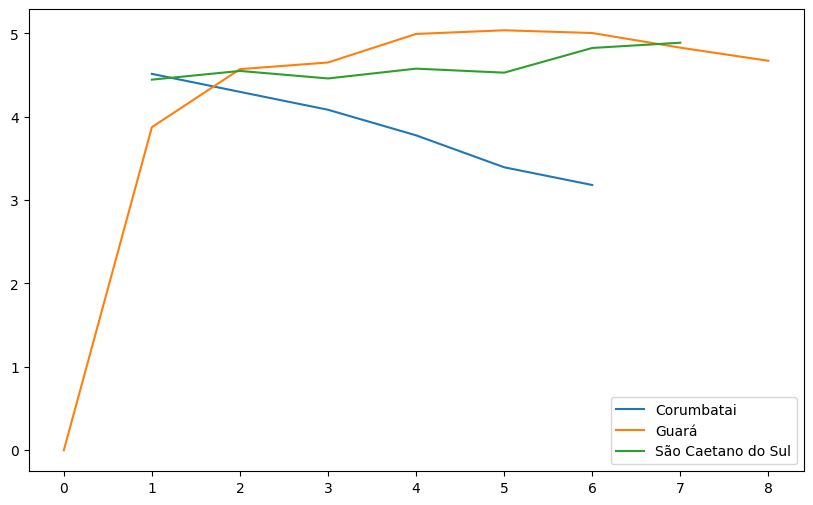

In [ ]:
# Plot the ratio between the average acess information between corumbatai and ER versus degree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(avg_ai_deg_corumbatai/avg_ai_deg_er_corumbatai[0: min(len(avg_ai_deg_corumbatai), len(avg_ai_deg_er_corumbatai))], label="Corumbatai")
plt.plot(avg_ai_deg_guara/avg_ai_deg_er_guara[0: min(len(avg_ai_deg_guara), len(avg_ai_deg_er_guara))], label="Guará")
plt.plot(avg_ai_deg_sao_caetano/avg_ai_deg_er_sao_caetano[0: min(len(avg_ai_deg_sao_caetano), len(avg_ai_deg_er_sao_caetano))], label="São Caetano do Sul")

plt.legend()
plt.show()

Entropia de alvo.

In [ ]:
def neighbor_path_fraction(graph, target_node):
    """
    Calculates the fraction of shortest paths to a target node which pass through each of its neighbors.

    Args:
        graph: A NetworkX graph.
        target_node: The target node.

    Returns:
        A dictionary where keys are neighbors of the target node and values
        are the fraction of shortest paths from all other nodes to the target
        node that pass through that neighbor.
    """
    path_counts = {}
    for neighbor in graph.neighbors(target_node):
        path_counts[neighbor] = 0

    # Get shortest paths from all other nodes to the target node
    shortest_paths = nx.shortest_path(graph, target=target_node)

    # Iterate through all source nodes (excluding the target node)
    for source_node, path in shortest_paths.items():
        if source_node != target_node:
            # Check if the path has more than one node (not a direct connection)
            if len(path) > 1:
                # The next node in the path from the source towards the target
                next_node = path[1]
                if next_node in path_counts:
                    path_counts[next_node] += 1

    total_paths = sum(path_counts.values())

    neighbor_fractions = {}
    for neighbor, count in path_counts.items():
        if total_paths > 0:
            neighbor_fractions[neighbor] = count / total_paths
        else:
            neighbor_fractions[neighbor] = 0 # Handle case where no other nodes exist or are directly connected

    return neighbor_fractions


In [ ]:
# prompt: Calculate the fraction of shortest paths that passess through a pair o

def edge_betweenness_fraction(graph, node1, betweenness_centrality):
    """
    Calculates the fraction of all-pairs shortest paths that pass through the edge (node1, node2).

    Args:
        graph: A NetworkX graph.
        node1: The first node of the edge.
        node2: The second node of the edge.

    Returns:
        The fraction of shortest paths passing through the edge (node1, node2).
    """
    # Ensure the edge exists in the graph

    fractions = []

    for node2 in graph.neighbors(node1):

      # The betweenness centrality for an edge (u, v) is the sum over all
      # pairs of distinct nodes (s, t) of the number of shortest (s, t) paths
      # that pass through (u, v), divided by the number of all shortest (s, t) paths.
      # The edge_betweenness_centrality function returns the normalized version
      # where the denominator is the number of pairs of distinct nodes (n*(n-1)/2 for undirected).

      # We need the unnormalized betweenness to find the fraction of paths.
      # The normalization factor for edge betweenness in an undirected graph is (n * (n - 1)) / 2.
      n = graph.number_of_nodes()
      normalization_factor = (n * (n - 1)) / 2.0

      unnormalized_betweenness = betweenness_centrality.get((node1, node2, 0), betweenness_centrality.get((node2, node1, 0), 0)) * normalization_factor



      # The total number of shortest paths between all pairs of nodes is not directly
      # returned by networkx betweenness centrality.
      # A simpler approach for fraction is to sum the unnormalized betweenness for all edges
      # and divide the target edge's unnormalized betweenness by this sum.
      # However, this is only valid if every shortest path contributes 1 to the sum of
      # betweenness values of edges it traverses, which is true.

      # Let's compute the sum of unnormalized betweenness for all edges
      total_unnormalized_betweenness = sum(betweenness_centrality.values()) * normalization_factor

      if total_unnormalized_betweenness > 0:
          fraction = unnormalized_betweenness / total_unnormalized_betweenness
      else:
          fraction = 0.0 # Handle cases with no paths (e.g., disconnected graph)

      fractions.append(fraction)

    return fractions

# Example usage:
# Replace node_u and node_v with two nodes from your graph sao_carlos
# You can find node IDs using sao_carlos.nodes
# node_u = list(sao_carlos.nodes)[0]
# node_v = list(sao_carlos.nodes)[1]
# fraction = edge_betweenness_fraction(sao_carlos, node_u, node_v)
# print(f"Fraction of shortest paths through edge ({node_u}, {node_v}): {fraction}")


# If you want the fraction of paths passing *through* two nodes sequentially
# (i.e., paths of the form A -> node1 -> node2 -> B), this is more complex
# and not directly captured by standard betweenness.
# The question "passes through two specific nodes" can be interpreted as
# passing through the edge connecting them. The function above calculates this.



In [ ]:
def target_entropy(graph: nx.Graph):
  TE = []

  for node in graph.nodes():
    # Count all the shortest paths that goes to node
    neighbor_fractions = neighbor_path_fraction(graph, node)

    # Calculate the entropy
    entropy = 0
    for neighbor, fraction in neighbor_fractions.items():
      entropy += fraction * np.log2(fraction)

    TE.append(-1 * entropy)

  return TE




In [ ]:
def target_entropy_medium(adjacency):
  TE = []

  for node in adjacency:
    # Count all the shortest paths that goes to node

    degree = node.sum()

    TE.append(- degree * 1/degree * np.log2(1/degree))

  return TE




Road entropy metric.

In [ ]:
def road_entropy(graph: nx.Graph):
  RE = []

  count = 0

  betweeness_centrality = nx.edge_betweenness_centrality(graph)
  print(betweeness_centrality)

  for node in graph:
    entropy = 0

    betweeness_fraction = edge_betweenness_fraction(graph, node, betweeness_centrality)

    for fraction in betweeness_fraction:
      if fraction != 0: entropy += fraction * np.log2(fraction)

    RE.append(-1 * entropy)
    count += 1

  return RE

In [ ]:
te_df = pd.DataFrame(target_entropy(corumbatai_dual))
te_df

<ipython-input-139-2560203283>:11: RuntimeWarning: divide by zero encountered in log2
  entropy += fraction * np.log2(fraction)
<ipython-input-139-2560203283>:11: RuntimeWarning: invalid value encountered in scalar multiply
  entropy += fraction * np.log2(fraction)


,0
0,-0.000000
1,1.000000
2,1.905639
3,NaN
4,0.970951
...,...
973,1.000000
974,1.000000
975,NaN
976,1.905639


In [ ]:
tf_df_medium = pd.DataFrame(target_entropy_medium(nx.adjacency_matrix(corumbatai_dual).todense()))
tf_df_medium

,0
0,-0.000000
1,1.000000
2,2.000000
3,2.000000
4,1.000000
...,...
973,1.000000
974,1.000000
975,1.584963
976,2.000000


In [ ]:
rf_df = pd.DataFrame(road_entropy(guara_dual))
rf_df

,0
0,0.000628
1,0.002768
2,0.000575
3,0.000799
4,0.015583
...,...
7681,0.000562
7682,0.015995
7683,0.002271
7684,0.013546


## Referências

[1] Hartwell LH, Hopfield JJ, Leibler S, Murray AW. From molecular to modular cell biology. Nature. 1999 Dec 2;402(6761 Suppl):C47-52. doi: 10.1038/35011540. PMID: 10591225.

[2] Rosvall, M., Trusina, A., Minnhagen, P., & Sneppen, K. (2005). Networks and Cities: An Information Perspective. Physical Review Letters, 94(2).

[3]
INSTITUTO BRASILEIRO DE GEOGRAFIA E ESTATÍSTICA. Cidades e Estados. Corumbataí (SP). Disponível em: https://www.ibge.gov.br/cidades-e-estados/sp/corumbatai.html.

[4]
INSTITUTO BRASILEIRO DE GEOGRAFIA E ESTATÍSTICA. Cidades e Estados. Guará (SP). Disponível em: https://www.ibge.gov.br/cidades-e-estados/sp/guara.html.

[5]
INSTITUTO BRASILEIRO DE GEOGRAFIA E ESTATÍSTICA. Cidades e Estados. São Caetano do Sul (SP) . Disponível em: https://www.ibge.gov.br/cidades-e-estados/sp/sao-caetano-do-sul.html.


[6] Boeing, G. 2025. “Modeling and Analyzing Urban Networks and Amenities with OSMnx.” Geographical Analysis, published online ahead of print. doi:10.1111/gean.70009

[7] RUBINOV, M.; SPORNS, O. Bctpy. Disponível em: https://pypi.org/project/bctpy/.